In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as scl
import time
from scipy.stats import norm

In [81]:
with open("german.data-numeric", "r") as ins:
    array = []
    for line in ins:
        array.append(line.split())

table = np.asarray(array).astype(int)

# Question 1

In [82]:
df = pd.DataFrame(table)
Y = df[24] - 1
Y = 2*Y - 1
df = df.drop(24, axis = 1)
df = df.rename(columns = {24 : 23})
df = (df - df.mean())/df.std()
df[25] = 1

# Algorithme de Gibbs

In [96]:
import numpy as np
from numpy import ndarray
from scipy.stats import truncnorm

def sample_truncated_gaussian(mean: ndarray, y, size=None):
    dim = len(mean)
    a = -mean
    b = -mean
    a[y < 0] = -np.inf
    b[y > 0] = np.inf
    if size is not None:
        size = (size, dim)
    z = truncnorm.rvs(a, b, loc=mean, size=size)
    return z

In [97]:
start = time.time()
n = df.shape[0]
d = df.shape[1]
tau = 100
precision_mat = np.eye(d) / tau + df.T @ df
cov_ = scl.pinvh(precision_mat)
mu = np.zeros((d,))
mu_s = []
beta = np.random.randn(d) * tau ** .5
betas = []
z = np.random.randn(n)
z_s = []
mu_op = cov_ @ df.T
for i in range(1000):
    beta = np.random.multivariate_normal(mu, cov = cov_)
    postmean = df@beta
    z = sample_truncated_gaussian(mean = postmean, y = Y)
    mu = mu_op@z
    mu_s.append(mu)
    betas.append(beta)
    z_s.append(z)
print("time is :", time.time() - start)

time is : 3.719512701034546


## Représentation de la distribution des paramètres

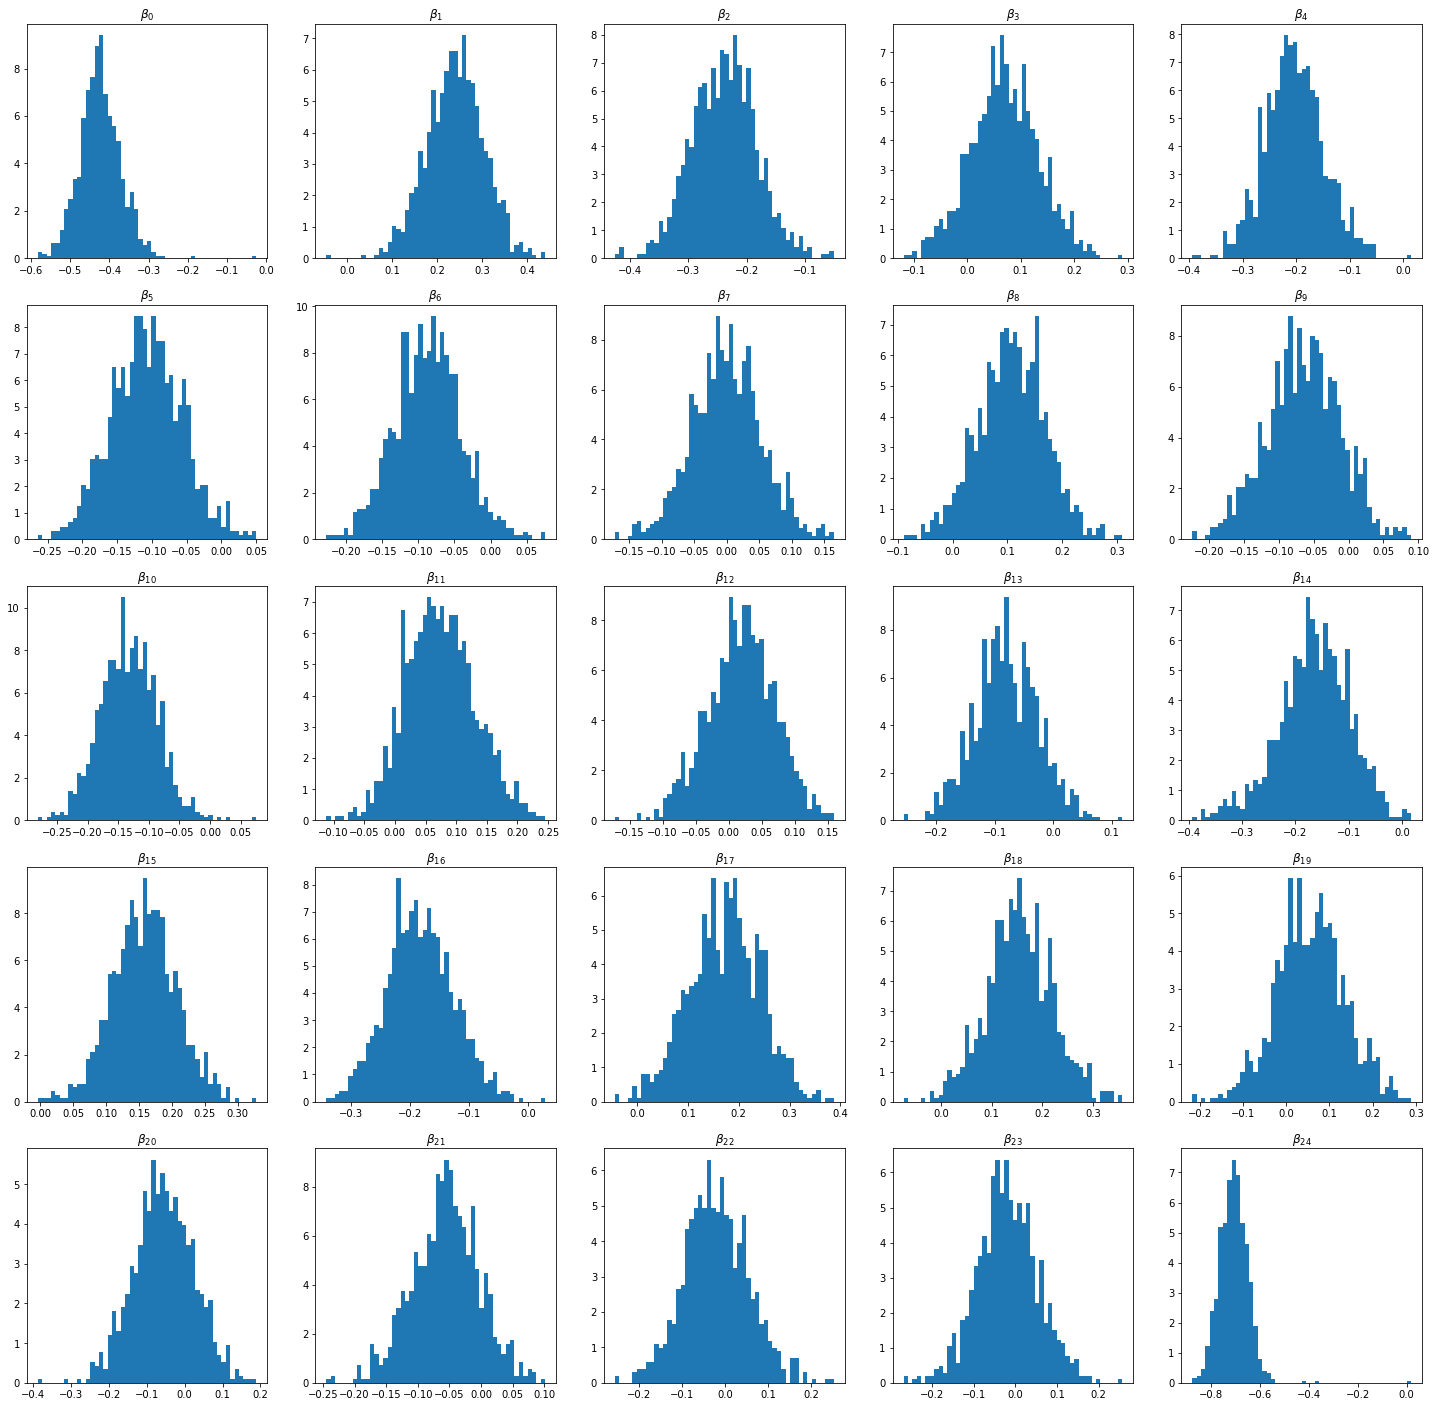

In [98]:
fig = plt.figure(figsize=(25, 25)) 
result = pd.DataFrame(betas) 
#result = result.iloc[50 : ][:]
plt.hist(result[20], bins = 50, density = True)
for i in range(0, len(result.columns)):
    plt.subplot(5, 5, i+1)
    plt.hist(result[i], bins = 50, density = True)
    plt.title("$\\beta_{%d}$" % i)

# Méthode mean-field

In [99]:
n = df.shape[0]
d = df.shape[1]
tau = 100
precision_mat = np.eye(d)/tau + np.array(df).T @ np.array(df)
cov_ = scl.pinvh(precision_mat)
beta_moy = np.random.rand(d)
z_moy = np.random.rand(n)
beta_convergence =[]
z_convergence = []
X = np.array(df)
for t in range(5000):
    beta_moy = cov_@ (X.T@z_moy)
    v = X@beta_moy
    z_moy = v + Y * norm.pdf(v)/norm.cdf(Y*v)

    

In [100]:
betas = np.random.multivariate_normal(beta_moy, cov_, size = 10000)
z_s = sample_truncated_gaussian(z_moy, Y, size = 10000)

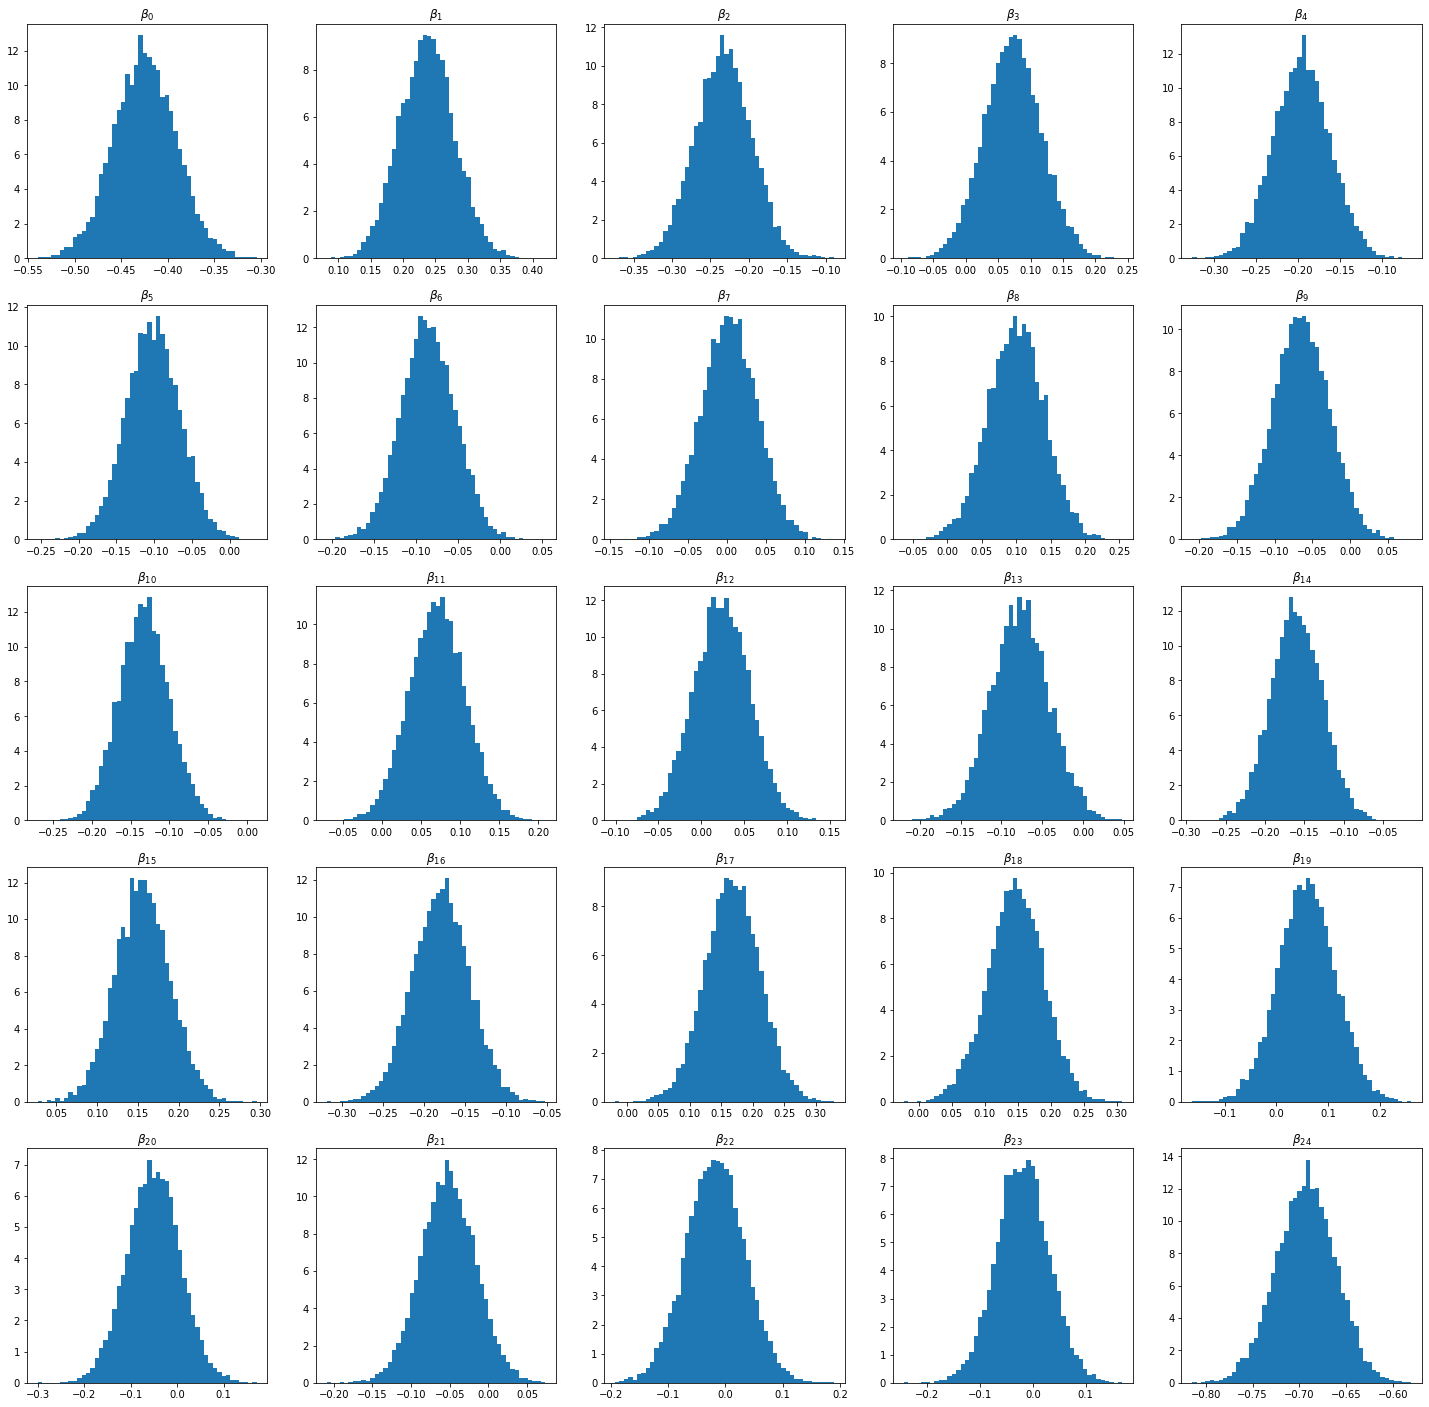

In [101]:
betas = pd.DataFrame(betas)
z_s = pd.DataFrame(z_s)
plt.figure(figsize = (25, 25))
for i in range(0, len(result.columns)):
    plt.subplot(5, 5, i+1)
    plt.hist(betas[i], bins = 50, density = True)
    plt.title("$\\beta_{%d}$" % i)

Text(0.5, 1.0, '$Z_{30}$')

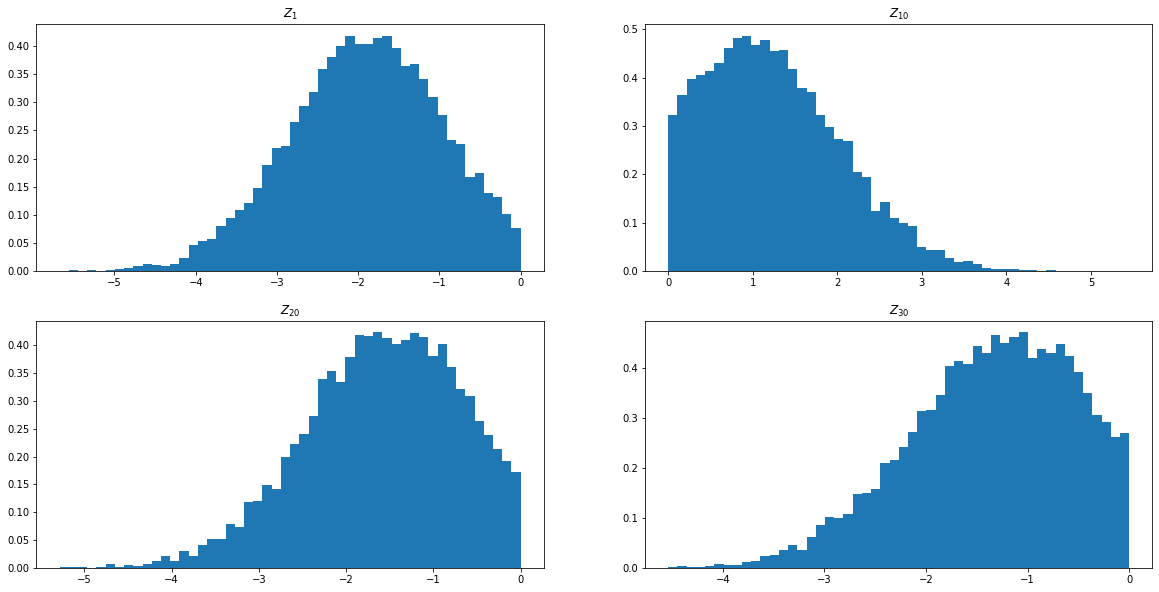

In [94]:
plt.figure(figsize = (20, 10))
plt.subplot(2, 2, 1)
plt.hist(z_s[0], bins = 50, density = True)
plt.title('$Z_1$')
plt.subplot(2, 2, 2)
plt.hist(z_s[10], bins = 50, density = True)
plt.title("$Z_{10}$")
plt.subplot(2, 2, 3)
plt.hist(z_s[20], bins = 50, density = True)
plt.title("$Z_{20}$")
plt.subplot(2, 2, 4)
plt.hist(z_s[30], bins = 50, density = True)
plt.title("$Z_{30}$")

# Comparaison des deux algorithmes

## separtation du dataset en deux partie (2/3, 1/3)

In [102]:
df = pd.DataFrame(table)
Y = df[24] - 1
Y = 2*Y - 1
df = df.drop(24, axis = 1)
df = df.rename(columns = {24 : 23})
df = (df - df.mean())/df.std()
df[25] = 1

In [103]:
X_train = df.loc[:633, :]
Y_train = Y[:634]
X_test = df.loc[633:, :]
Y_test = Y[634 : ]

In [104]:
Y_train

0     -1
1      1
2     -1
3     -1
4      1
      ..
629   -1
630   -1
631    1
632   -1
633    1
Name: 24, Length: 634, dtype: int64

## Prediction par Gibbs

In [105]:
start = time.time()
n = X_train.shape[0]
d = X_train.shape[1]
tau = 100
precision_mat = np.eye(d) / tau + X_train.T @ X_train
cov_ = scl.pinvh(precision_mat)
mu = np.zeros((d,))
mu_s = []
beta = np.random.randn(d) * tau ** .5
betas = []
z = np.random.randn(n)
z_s = []
mu_op = cov_ @ X_train.T
for i in range(1000):
    beta = np.random.multivariate_normal(mu, cov = cov_)
    postmean = X_train@beta
    z = sample_truncated_gaussian(mean = postmean, y = Y_train)
    mu = mu_op@z
    mu_s.append(mu)
    betas.append(beta)
    z_s.append(z)
print("time is :", time.time() - start)

time is : 3.256467819213867


In [106]:
betas = pd.DataFrame(betas)
betas_moy = betas.mean(axis = 0)
epsilon = np.random.randn(367)
epsilon = epsilon.reshape((367, 1))
betas_moy = np.array(betas_moy).reshape((25, 1))

result = np.sign(X_test@betas_moy + epsilon)

In [107]:
compare = pd.concat([Y_test, result], axis = 1)
equal = len(compare[compare[24]==compare[0]])
print(equal/len(Y_test))

0.7076502732240437


## Prédiction par Mean-Field 

In [108]:
n = X_train.shape[0]
d = X_train.shape[1]
tau = 100
precision_mat = np.eye(d)/tau + np.array(X_train).T @ np.array(X_train)
cov_ = scl.pinvh(precision_mat)
beta_moy = np.random.rand(d)
z_moy = np.random.rand(n)
beta_convergence =[]
z_convergence = []
X = np.array(X_train)
for t in range(5000):
    beta_moy = cov_@ (X.T@z_moy)
    v = X@beta_moy
    z_moy = v + Y_train * norm.pdf(v)/norm.cdf(Y_train*v)


In [109]:
betas = np.random.multivariate_normal(beta_moy, cov_, size = 10000)
z_s = sample_truncated_gaussian(z_moy, Y, size = 10000)

In [110]:
betas = pd.DataFrame(betas)
betas_moy = betas.mean(axis = 0)
epsilon = np.random.randn(367)
epsilon = epsilon.reshape((367, 1))
betas_moy = np.array(betas_moy).reshape((25, 1))

result = np.sign(X_test@betas_moy + epsilon)

In [111]:
compare = pd.concat([Y_test, result], axis = 1)
equal = len(compare[compare[24]==compare[0]])
print(equal/len(Y_test))

0.7021857923497268


## Temps de convergence de Mean-Field 

In [119]:
n = df.shape[0]
d = df.shape[1]
tau = 100
precision_mat = np.eye(d)/tau + np.array(df).T @ np.array(df)
cov_ = scl.pinvh(precision_mat)
beta_moy = np.random.randn(d)
z_moy = np.random.rand(n)
beta_convergence =[]
z_convergence = []
X = np.array(df)
for t in range(5000):
    beta_new = cov_@ (X.T@z_moy)
    beta_convergence.append(np.linalg.norm(beta_new - beta_moy, ord = 1))
    beta_moy[:] = beta_new
    v = X@beta_moy
    z_new = v + Y * norm.pdf(v)/norm.cdf(Y*v)
    z_convergence.append(np.linalg.norm(z_new - z_moy, ord = 1))
    z_moy[:] = z_new

    

Text(0, 0.5, 'log($\\||z_i - z_{(i-1)}\\||$)')

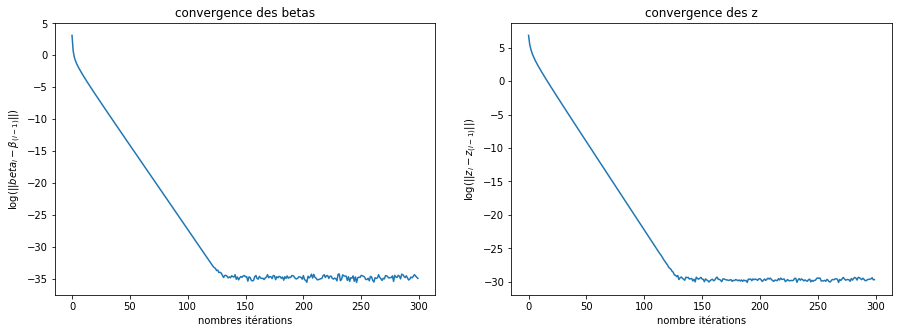

In [118]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot([x for x in range(300)], np.log(beta_convergence[:300]))
plt.title("convergence des betas")
plt.xlabel('nombres itérations')
plt.ylabel('log($\\||beta_i - \\beta_{(i-1)}||$)')
plt.subplot(1, 2, 2)
plt.plot([x for x in range(300)], np.log(z_convergence[:300]))
plt.title("convergence des z")
plt.xlabel('nombre itérations')
plt.ylabel('log($\\||z_i - z_{(i-1)}\\||$)')

## Comparaison des temps d'éxecutions des deux algorithmes

In [120]:
t1 = time.time()
n = df.shape[0]
d = df.shape[1]
tau = 100
precision_mat = np.eye(d)/tau + np.array(df).T @ np.array(df)
cov_ = scl.pinvh(precision_mat)
beta_moy = np.random.randn(d)
z_moy = np.random.rand(n)
X = np.array(df)
for t in range(170):
    beta_moy = cov_@ (X.T@z_moy)
    v = X@beta_moy
    z_moy = v + Y * norm.pdf(v)/norm.cdf(Y*v)
betas = np.random.multivariate_normal(beta_moy, cov_, size = 1000)
z_s = sample_truncated_gaussian(z_moy, Y, size = 1000)    
t2 = time.time()
print('time for mean-field is:', t2 - t1)

time for mean-field is: 0.2652289867401123


## Comparaison des distributions estimées

In [66]:

n = df.shape[0]
d = df.shape[1]
tau = 100
precision_mat = np.eye(d) / tau + df.T @ df
cov_ = scl.pinvh(precision_mat)
mu = np.zeros((d,))
mu_s = []
beta = np.random.randn(d) * tau ** .5
betas_g = []
z = np.random.randn(n)
z_s_g = []
mu_op = cov_ @ df.T
for i in range(1000):
    beta = np.random.multivariate_normal(mu, cov = cov_)
    postmean = df@beta
    z = sample_truncated_gaussian(mean = postmean, y = Y)
    mu = mu_op@z
    mu_s.append(mu)
    betas_g.append(beta)
    z_s_g.append(z)

In [67]:
n = df.shape[0]
d = df.shape[1]
tau = 100
precision_mat = np.eye(d)/tau + np.array(df).T @ np.array(df)
cov_ = scl.pinvh(precision_mat)
beta_moy = np.random.randn(d)
z_moy = np.random.rand(n)
X = np.array(df)
for t in range(170):
    beta_moy = cov_@ (X.T@z_moy)
    v = X@beta_moy
    z_moy = v + Y * norm.pdf(v)/norm.cdf(Y*v)
betas_mf = np.random.multivariate_normal(beta_moy, cov_, size = 1000)
z_s_mf = sample_truncated_gaussian(z_moy, Y, size = 1000) 

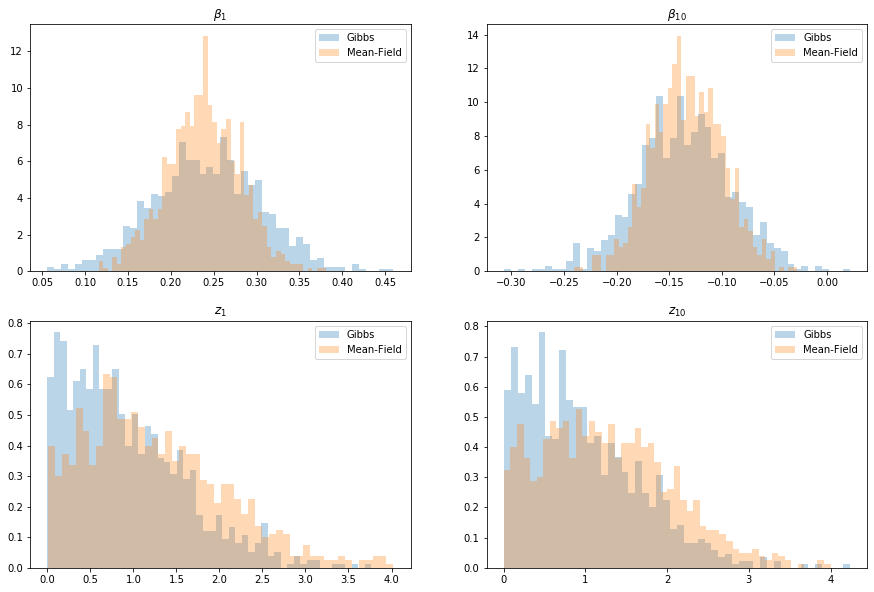

In [79]:
plt.figure(figsize = (15, 10))
plt.subplot(2, 2, 1)
plt.hist(pd.DataFrame(betas_g)[1], alpha = 0.3, bins = 50, density = True)
plt.hist(pd.DataFrame(betas_mf)[1], alpha = 0.3, bins = 50, density = True)
plt.title('$\\beta_{1}$')
plt.legend(['Gibbs', 'Mean-Field'])
plt.subplot(2, 2, 2)
plt.hist(pd.DataFrame(betas_g)[10], alpha = 0.3, bins = 50, density = True)
plt.hist(pd.DataFrame(betas_mf)[10], alpha = 0.3, bins = 50, density = True)
plt.title('$\\beta_{10}$')
plt.legend(['Gibbs', 'Mean-Field'])
plt.subplot(2, 2, 3)
plt.hist(pd.DataFrame(z_s_g)[1], alpha = 0.3, bins = 50, density = True)
plt.hist(pd.DataFrame(z_s_mf)[1], alpha = 0.3, bins = 50, density = True)
plt.title('$z_{1}$')
plt.legend(['Gibbs', 'Mean-Field'])
plt.subplot(2, 2, 4)
plt.hist(pd.DataFrame(z_s_g)[10], alpha = 0.3, bins = 50, density = True)
plt.hist(pd.DataFrame(z_s_mf)[10], alpha = 0.3, bins = 50, density = True)
plt.title('$z_{10}$')
plt.legend(['Gibbs', 'Mean-Field'])

# Séparation complète des données

## Génération de données avec existence d'une sépration complète

In [297]:
x = np.random.rand(200)
y = np.random.rand(200)

In [298]:
tab = pd.concat([pd.Series(x), pd.Series(y)], axis = 1)

In [299]:
tab[2] = tab[1] >= tab[0] + 0.05

In [300]:
tab[3] = tab[1]<= tab[0] - 0.05

In [301]:
index_to_drop = []
for i in range(len(tab.loc[:, 0])):
    if tab.loc[i, 2]==False and tab.loc[i, 3]==False:
        index_to_drop.append(i)

In [302]:
tab1 = tab.drop(index_to_drop, axis = 0)

In [303]:
tab_finale = tab1.drop(3, axis = 1)

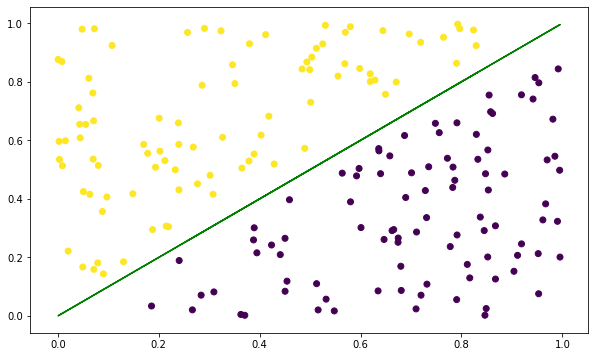

In [307]:
fig = plt.figure(figsize=(10, 6))
plt.scatter(tab_finale[0], tab_finale[1], c = tab_finale[2])
plt.plot(tab_finale[0], tab_finale[0], c = 'g')
plt.title('données avec séparation')

## Application de Gibbs sur ces données

In [317]:

X = tab_finale.loc[:, 0:1]
Y = tab_finale.loc[:, 2]
Y = Y.replace(True, 1)
Y = Y.replace(False, -1)
n = X.shape[0]
d = X.shape[1]
tau = 100
precision_mat = np.eye(d) / tau + X.T @ X
cov_ = scl.pinvh(precision_mat)
mu = np.zeros((d,))
mu_s = []
beta = np.random.randn(d) * tau ** .5
betas = []
z = np.random.randn(n)
z_s = []
mu_op = cov_ @ X.T
for i in range(1000):
    beta = np.random.multivariate_normal(mu, cov = cov_)
    postmean = X@beta
    z = sample_truncated_gaussian(mean = postmean, y = Y)
    mu = mu_op@z
    mu_s.append(mu)
    betas.append(beta)
    z_s.append(z)

## Visualisation des paramètres

Text(0.5, 1.0, 'chaine de Markov pour $Z_3$')

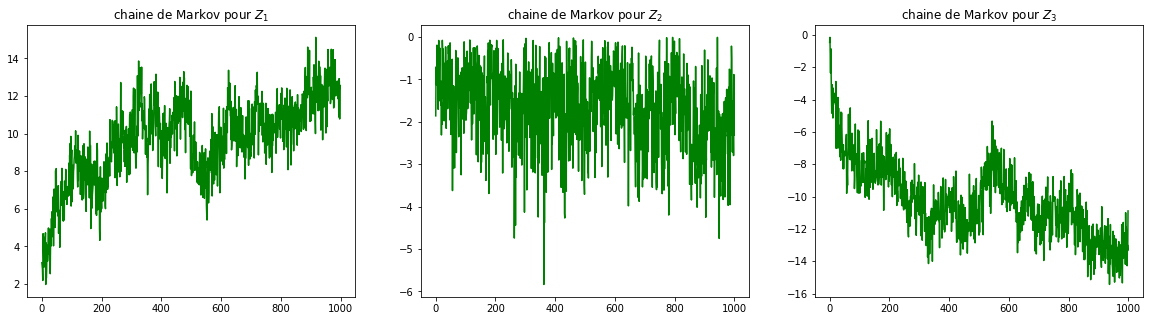

In [335]:
z_s = pd.DataFrame(z_s)
plt.figure(figsize = (20, 5))
plt.subplot(1, 3, 1)
plt.plot([i for i in range(1000)], z_s.loc[:, 0], color = 'g')
plt.title('chaine de Markov pour $Z_1$')
plt.subplot(1, 3, 2)
plt.plot([i for i in range(1000)], z_s.loc[:, 1], color = 'g')
plt.title('chaine de Markov pour $Z_2$')
plt.subplot(1, 3, 3)
plt.plot([i for i in range(1000)], z_s.loc[:, 3], color = 'g')
plt.title('chaine de Markov pour $Z_3$')

Text(0.5, 1.0, 'Distribution estimée de $\\beta_{1}$')

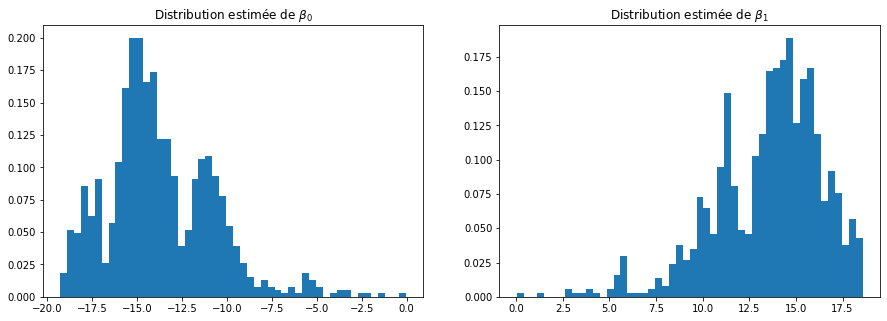

In [350]:
betas = pd.DataFrame(betas)
plt.figure(figsize = (15, 5))
plt.subplot(1,2, 1)
plt.hist(betas[0], bins = 50, density = True)
plt.title('Distribution estimée de $\\beta_{0}$')
plt.subplot(1, 2, 2)
plt.hist(betas[1], bins = 50, density = True)
plt.title('Distribution estimée de $\\beta_{1}$')